In [330]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import yfinance as yf
import dash
from dash import dcc, html
from dash.dash_table import DataTable, FormatTemplate
import dash_bootstrap_components as dbc

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.float_format', lambda x: '%.4f' % x)

###  ToDo:
* zrobić coś w stylu inital_concept.jpg
* skupić się na razie na portfelu ETF
* Wykres NetWorth to można zrobić coś w stylu, że jest interwał miesięczny, poczynając od miesiąca z daty pierwszej transakcji kupna etfa i potem już co miesiąc, gdzie po prostu biorę co miesiąc sumę wszytskich aktywów i przemnażam przez ich cenę z tego okresu (data końca miesiąca albo średnia miesięczna cena dla każdego tickera), co daje mi jedną obserwację na wykresie
    * z tego w sumie może powstać wykres gdzie jedna linia jest mnożona przez cenę i pokazuje realną zmienność portfela, a druga linia jest tylko wpłatami kapitału, czyli za ile coś kupiłem, to by fajnie pokazywało jaka jest relacja wpłacanego kapitału do realnej wartości portfela
    * można by też wtedy dodać kolory, że jak linia wartości jest wyżej niż wpłacania, to zysk - zielony, a jak spadnie poniżej wpłacony kapitał, to strata - czerwony
* Wykres Allocations zrobić analogiczny do kołowych wykresów u mnie w excelu, ale z jakąś agregacją etfów z danego typu np. DTLA i IDTL wyświetlane jako jedna pozycja podpisana "US tre 20+". Dalsza granulacja na konta i poszczególne etfy może być w dalszym podsumowaniu (może osobne strony dla każdego brokera czy coś, chociaż nie wiem czy jest sens)
* Dodać w zakładce Holdings kolumnę z info o koncie na jakim jest kupiony dany ticker

### Data loading

In [247]:
df_raw = pd.read_excel('data/transactions.xlsx')

In [248]:
df = df_raw.copy()

### Data preparation

In [162]:
df.account.unique()

array(['treasury_bonds_pl', 'ikze', 'xtb', 'ike'], dtype=object)

In [163]:
df_group = df[['account', 'ticker', 'asset_type', 'amount','total_pln']]

In [164]:
df_group['quarter'] = df['date'].dt.year.astype(str) + "Q" + df['date'].dt.quarter.astype(str)

In [376]:
# df_group.groupby(['account', 'asset_type']).sum()['total_pln'].reset_index()

In [377]:
# df_group.groupby(['asset_type', 'quarter']).sum()['total_pln'].reset_index()

In [167]:
df_pivot = pd.pivot_table(df_group, values='total_pln', index='quarter', columns='asset_type', aggfunc='sum', fill_value=0)

### Plots by quarter

In [374]:
# df_pivot.plot( 
#     # x = 'quarter', 
#     kind = 'barh', 
#     stacked = True, 
#     title = 'Buys by quarter', 
#     mark_right = True) 

In [171]:
for i in range(1, len(df_pivot)):
    r = df_pivot.index[i]
    print(r)
    r1 = df_pivot.index[i-1]
    for c in df_pivot.columns:
        if df_pivot.loc[r, c] == 0:
            df_pivot.loc[r, c] = df_pivot.loc[r1, c]
        if df_pivot.loc[r, c] != df_pivot.loc[r1, c]:
            df_pivot.loc[r, c] = df_pivot.loc[r, c] + df_pivot.loc[r1, c]

2023Q1
2023Q2
2023Q3
2023Q4
2024Q1


In [173]:
df_prc = df_pivot.div(df_pivot.sum(axis=1), axis=0).reset_index()

In [375]:
# df_prc.plot( 
#     kind = 'barh', 
#     stacked = True, 
#     title = 'Portfolio composition in time', 
#     # mark_right = True
# )

In [176]:
df_plot = pd.melt(df_prc, id_vars='quarter', value_vars=list(df_prc.columns[1:]), var_name='asset_type', value_name='total_pln')

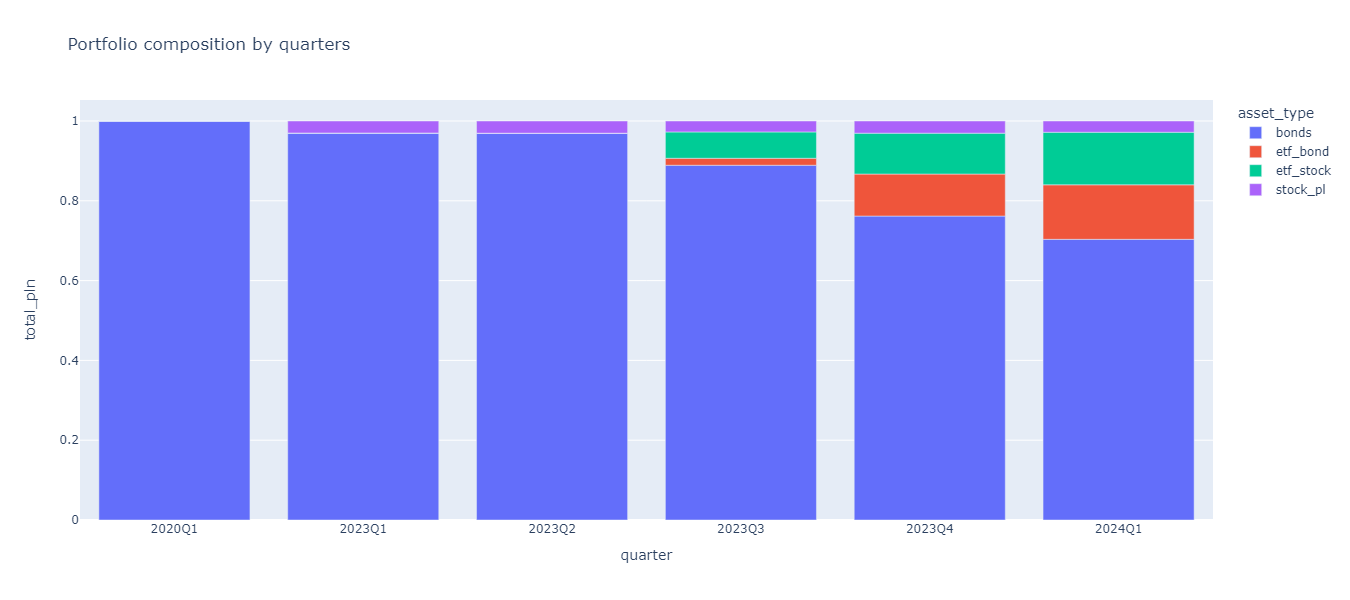

In [314]:
fig = px.bar(df_plot, x="quarter", y="total_pln", color="asset_type", title="Portfolio composition by quarters")

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    # paper_bgcolor="LightSteelBlue",
)

fig.show()

### Holdings table

In [250]:
def get_current_price(symbol):
    ticker = yf.Ticker(symbol)
    todays_data = ticker.history(period='1d')
    return todays_data['Close'][0]

In [307]:
def holdings_table(tickers):
    holdings = pd.DataFrame(columns=['ticker', 'currency', 'asset_type', 'amount', 'avg_buy_price', 'current_price', 'return_pct'])
    for t in tickers:
        print(t)
        ticker = df[(df['ticker'] == t) & (df['transaction_type'] == 'buy')]
        ticker['total_cur'] = ticker['amount'] * ticker['price']
        ticker_agg = ticker[['ticker', 'currency', 'asset_type', 'amount', 'price']].groupby(['ticker', 'currency', 'asset_type']).sum().reset_index()
        ticker_agg.loc[0, 'price'] = ticker['total_cur'].sum() / ticker['amount'].sum() 
        ticker_agg = ticker_agg.rename(columns={'price': 'avg_buy_price'})
        ticker_agg['current_price'] = get_current_price(t)
        ticker_agg['return_pct'] = (ticker_agg['current_price'] - ticker_agg['avg_buy_price']) / ticker_agg['avg_buy_price']
        holdings = pd.concat([holdings, ticker_agg])
    holdings = holdings.reset_index(drop=True)
    holdings['avg_buy_price'] = holdings['avg_buy_price'].map("{:,.4f}".format)
    holdings['current_price'] = holdings['current_price'].map("{:,.4f}".format)
    holdings['return_pct'] = holdings['return_pct'] * 100
    holdings['return_pct'] = holdings['return_pct'].map('{:,.2f}%'.format)
    return holdings

In [308]:
def portfolio_return(holdings):
    current = (holdings['current_price'] * holdings['amount']).sum()
    initial = (holdings['avg_buy_price'] * holdings['amount']).sum()
    return round(((current - initial) / initial), 4)

In [309]:
holdings_etfs = holdings_table(df[df['asset_type'].str.contains('etf')]['ticker'].unique())

EIMI.L
DTLA.L
SWRD.L
IDTL.L
VWRL.AS


In [236]:
print("ETF portfolio return: ", portfolio_return(holdings_etfs))

ETF portfolio return:  0.0602


In [218]:
# woodpecker nie jest na zagranicznych listach, więc nie ma tickera
bought_pl = df[df['asset_type'].str.contains('pl')]['ticker'].unique()
sold_pl = df[(df['asset_type'].str.contains('pl')) & (df['transaction_type'] == 'sell')]['ticker'].unique()
holdings_pl = holdings_table(np.setdiff1d(bought_pl, np.append(sold_pl, 'WPR.WA')))

1AT.WA
ALL.WA
APR.WA
ASE.WA
BCS.WA
CDR.WA
VOT.WA
WTN.WA


In [235]:
print("PL portfolio return: ", portfolio_return(holdings_pl))

PL portfolio return:  0.0964


### Net Worth Table

In [38]:
def history_calculation(df_pivot):
    for i in range(1, len(df_pivot)):
        r = df_pivot.index[i]
        r1 = df_pivot.index[i-1]
        for c in df_pivot.columns:
            if df_pivot.loc[r, c] == 0:
                df_pivot.loc[r, c] = df_pivot.loc[r1, c]
            if df_pivot.loc[r, c] != df_pivot.loc[r1, c]:
                df_pivot.loc[r, c] = df_pivot.loc[r, c] + df_pivot.loc[r1, c]
    return df_pivot

In [59]:
import datetime

def last_day_of_month(any_day):
    # The day 28 exists in every month. 4 days later, it's always next month
    next_month = any_day.replace(day=28) + datetime.timedelta(days=4)
    # subtracting the number of the current day brings us back one month
    return next_month - datetime.timedelta(days=next_month.day)

In [148]:
def net_worth_plot_data(df):
    currencies = df[['ticker', 'currency']].drop_duplicates()
    df_group = df[['account', 'ticker', 'currency', 'asset_type', 'transaction_type', 'amount', 'price', 'commision', 'pln_exr', 'total_pln']]
    df_group['date_month'] = df['date'].astype(str).str[:7]
    
    df_pivot_capital_init = pd.pivot_table(df_group, values='total_pln', index='date_month', columns='ticker', aggfunc='sum', fill_value=0)
    df_pivot_amount = pd.pivot_table(df_group, values='amount', index='date_month', columns='ticker', aggfunc='sum', fill_value=0)

    df_pivot_capital_init = history_calculation(df_pivot_capital_init)
    df_pivot_amount = history_calculation(df_pivot_amount)
    
    start_dates = list(df_pivot_amount.index + str("-01"))

    end_dates = []

    for i in range(0, len(start_dates)):
        year = pd.to_datetime(start_dates)[i].year
        month = pd.to_datetime(start_dates)[i].month
        end_dates.append(str(last_day_of_month(datetime.date(year, month, 1))))
        
    for ticker in df_pivot_amount.columns:
        for i in range(0, len(start_dates)):
            if ticker == 'EIMI.L':
                avg_price = yf.download('EMIM.AS', start_dates[i], end_dates[i])['Close'].mean()
            else:
                avg_price = yf.download(ticker, start_dates[i], end_dates[i])['Close'].mean()
            amount = df_pivot_amount.loc[df_pivot_amount.index[i], ticker]
            if currencies[currencies['ticker'] == ticker]['currency'].reset_index(drop=True)[0] == 'USD':
                pln = yf.download('USDPLN=X', start_dates[i], end_dates[i])['Close'].mean()
            if (currencies[currencies['ticker'] == ticker]['currency'].reset_index(drop=True)[0] == 'EUR') | (ticker == 'EIMI.L'):
                pln = yf.download('EURPLN=X', start_dates[i], end_dates[i])['Close'].mean()
            df_pivot_amount.loc[df_pivot_amount.index[i], ticker] = amount * avg_price * pln
    
    df_plot = pd.concat([df_pivot_capital_init.sum(axis=1), df_pivot_amount.sum(axis=1)], axis=1)
    df_plot.columns = ['capital', 'asset_value']
    
    return df_plot

In [149]:
# tymczasowo ograniczam się do ETFów
df_nw = df[df['asset_type'].str.contains('etf')].reset_index(drop=True)

In [234]:
df_nw_plot = net_worth_plot_data(df_nw).reset_index()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [235]:
df_nw_plot['asset_value'] = df_nw_plot['asset_value'] - df_nw_plot['capital']

In [236]:
df_nw_plot = pd.melt(df_nw_plot, id_vars='date_month', value_vars=list(df_nw_plot.columns[1:]), var_name='class', value_name='value_pln')

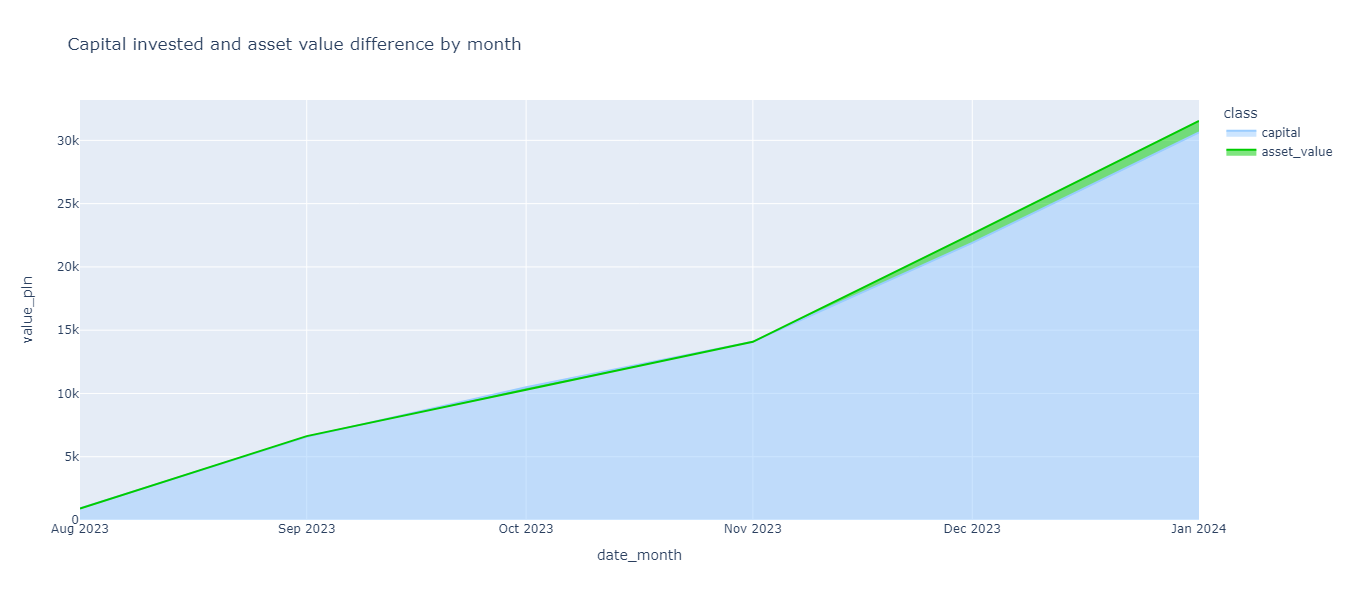

In [225]:
# jesli chcialbym kiedys sie pobawic w kolory to tu: https://community.plotly.com/t/it-is-possible-to-fill-area-with-different-colors-on-a-line-plot/31664/8

fig = px.area(df_nw_plot, 
              x="date_month", 
              y="value_pln", 
              color='class', 
              line_group='class', 
              title="Capital invested and asset value difference by month",
              color_discrete_sequence=["#99ccff", "#00cc00"]
             )

fig.update_layout(
    autosize=False,
    width=1000,
    height=600,
    # paper_bgcolor="LightSteelBlue",
)

fig.show()

### Dashboard 

In [373]:
# Create a Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

percentage = FormatTemplate.percentage(2)

app.layout = html.Div([
    html.H1("ETF Portfolio Dashboard", style={'textAlign': 'center', 'fontSize': '35px', 'margin-bottom': '40px'}),

    dbc.Row([
        dbc.Col([
            html.H2("Holdings", style={'textAlign': 'center', 'fontSize': '25px', 'margin-bottom': '70px'}),
            html.Div([
                DataTable(
                    id='data-table',
                    columns=[{'name': col, 'id': col} for col in holdings_etfs.columns],

                    data=holdings_etfs.to_dict('records'),
                    style_as_list_view=True,
                    style_cell={'padding': '5px', 'fontSize': 18},
                    style_header={
                        'backgroundColor': 'white',
                        'fontWeight': 'bold'
                    },
                    style_table={'width': '90%'},
                ),
            ]),
        ], width=5),

        dbc.Col([
            html.Div([
                html.H2("Capital invested and asset value difference by month", style={'textAlign': 'center', 'fontSize': '25px'}),
                dcc.Graph(
                    id='area-chart',
                    figure=px.area(
                        df_nw_plot,
                        x="date_month",
                        y="value_pln",
                        color='class',
                        line_group='class',
                        color_discrete_sequence=["#99ccff", "#00cc00"]
                    ).update_layout(
                        autosize=True,
                        # autosize=False,
                        # width=900,
                        # height=500,
                    )
                ),
            ]),
        ], width=5)
    ]),
    dbc.Row([
        dbc.Col([
            html.Div([
                html.H2("Portfolio composition by quarters", style={'textAlign': 'center', 'fontSize': '25px'}),
                dcc.Graph(
                    id='bar-chart',
                    figure=px.bar(
                        df_plot,
                        x="quarter",
                        y="total_pln",
                        color='asset_type',
                        color_discrete_sequence=["#006600", "#009900", "#ff8000", "#ff6666"]
                    ).update_layout(
                        autosize=True,
                        # autosize=False,
                        # width='70%',
                        # height='70%',
                    )
                )
            ])
        ], width=5)
    ])
    
], style={'height': '30%', 'margin': '20px'})


# Run the app
if __name__ == '__main__':
    app.run_server(jupyter_mode='external')


Dash app running on http://127.0.0.1:8050/
